In [ ]:
import os
import pandas as pd
from langid import classify

import matplotlib.pyplot as plt
import re
from collections import Counter
import numpy as np

# Importing dataset

In [39]:
li = []
for filename in os.listdir("../challenge_data/train_tweets"):
    df = pd.read_csv("../challenge_data/train_tweets/" + filename)
    li.append(df)
df = pd.concat(li, ignore_index=True)

In [24]:
print(df.head())
print("\n")
print(df.shape)

    ID  MatchID  PeriodID  EventType      Timestamp  \
0  2_0        2         0          0  1403538600000   
1  2_0        2         0          0  1403538600000   
2  2_0        2         0          0  1403538600000   
3  2_0        2         0          0  1403538600000   
4  2_0        2         0          0  1403538600000   

                                               Tweet  Character_Count  
0  RT @soccerdotcom: If #ESP beats #AUS we'll giv...              140  
1  Visit the #SITEP official web site here http:/...              135  
2  RT @soccerdotcom: If #ESP beats #AUS we'll giv...              140  
3  RT @worldsoccershop: If there is a winner in t...              140  
4  RT @soccerdotcom: If #AUS beats #ESP we'll giv...              140  


(5056050, 7)


In [44]:
matches = {}
for filename in os.listdir("../challenge_data/train_tweets"):
    df_ = pd.read_csv("../challenge_data/train_tweets/" + filename)["MatchID"]
    match_id = df_.iloc[0]
    matches[match_id] = filename[:-6]

print(matches)

{2: 'AustraliaSpain', 3: 'PortugalGhana', 8: 'CameroonBrazil', 1: 'GermanyBrazil', 14: 'BelgiumSouthKorea', 7: 'NetherlandsChile', 4: 'GermanyAlgeria', 5: 'FranceGermany', 19: 'MexicoCroatia', 13: 'FranceNigeria', 12: 'AustraliaNetherlands', 0: 'HondurasSwitzerland', 10: 'ArgentinaGermanyFinal', 11: 'ArgentinaBelgium', 18: 'USASlovenia20', 17: 'GermanyUSA'}


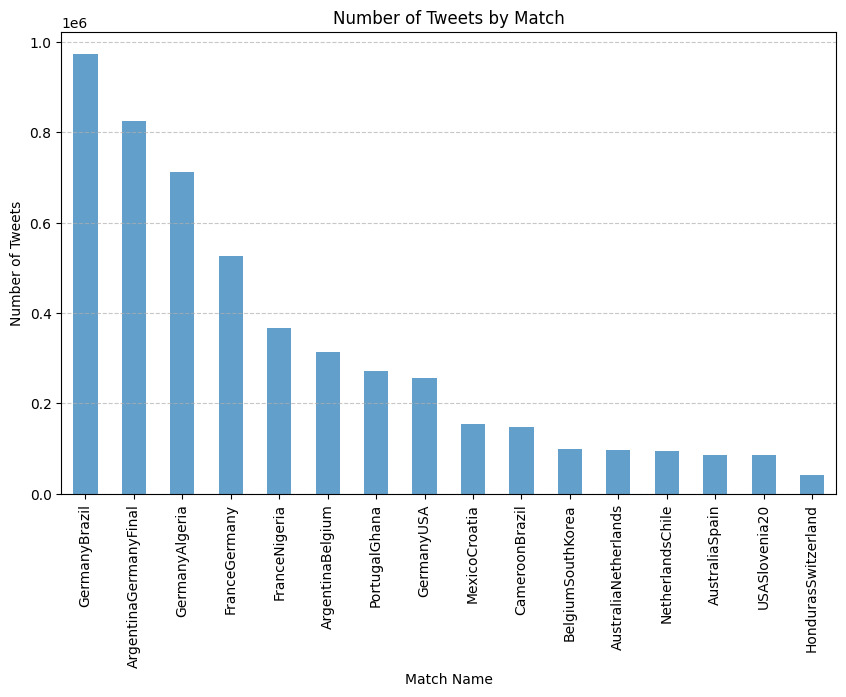

In [45]:
# Plot histogram of the number of tweets by match
plt.figure(figsize=(10, 6))
df['MatchID'].map(matches).value_counts().plot(kind='bar', alpha=0.7)
plt.title("Number of Tweets by Match")
plt.xlabel("Match Name")
plt.ylabel("Number of Tweets")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

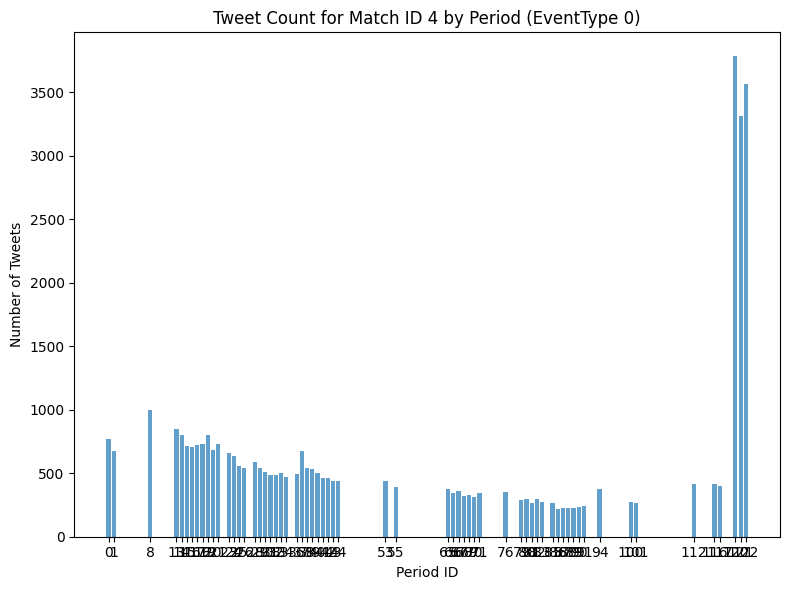

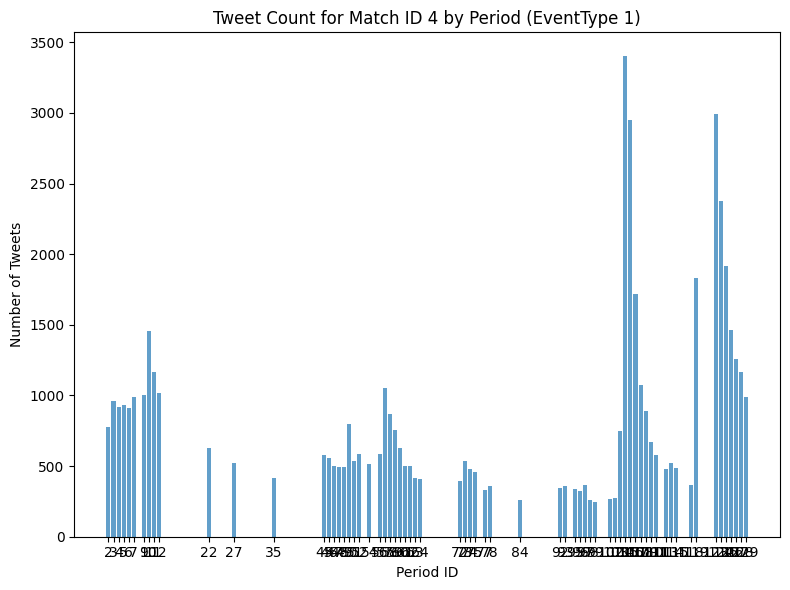

In [ ]:
# Filter data for MatchID = 7
match_data = df[df['MatchID'] == 7]

# Group by PeriodID and EventType, counting tweets
tweets_by_period_event = match_data.groupby(['PeriodID', 'EventType']).size().reset_index(name='Tweet_Count')

# Plot the results
for event_type in tweets_by_period_event['EventType'].unique():
    subset = tweets_by_period_event[tweets_by_period_event['EventType'] == event_type]
    plt.figure(figsize=(8, 6))
    plt.bar(subset['PeriodID'], subset['Tweet_Count'], alpha=0.7)
    plt.title(f"Tweet Count for Match ID 7 by Period (EventType {event_type})")
    plt.xlabel("Period ID")
    plt.ylabel("Number of Tweets")
    plt.xticks(subset['PeriodID'])
    plt.tight_layout()
    plt.show()

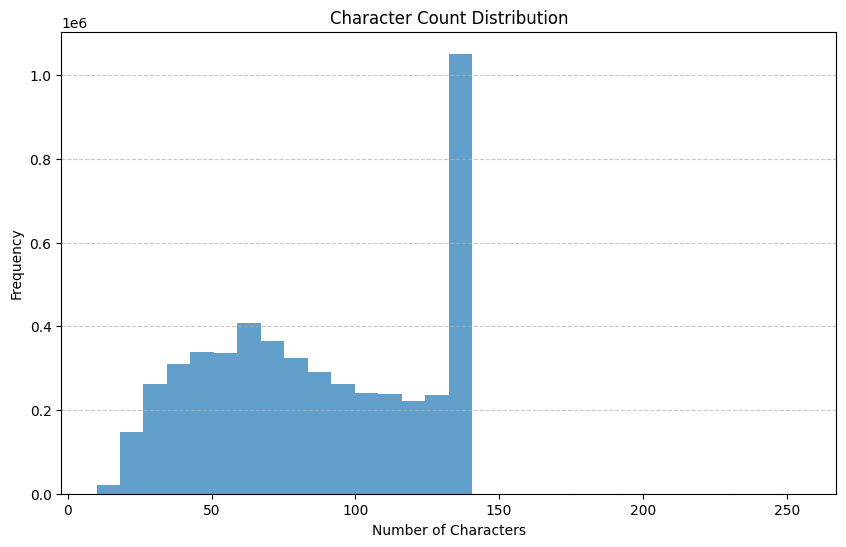

In [28]:
# Analyze tweets: number of characters, language, and hashtags
df['Character_Count'] = df['Tweet'].apply(len)
# Plot histogram of character counts
plt.figure(figsize=(10, 6))
df['Character_Count'].plot(kind='hist', bins=30, alpha=0.7)
plt.title("Character Count Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


begin of select
end of select
begin of count words 0
end of count words 0
begin of count words 1
end of count words 1


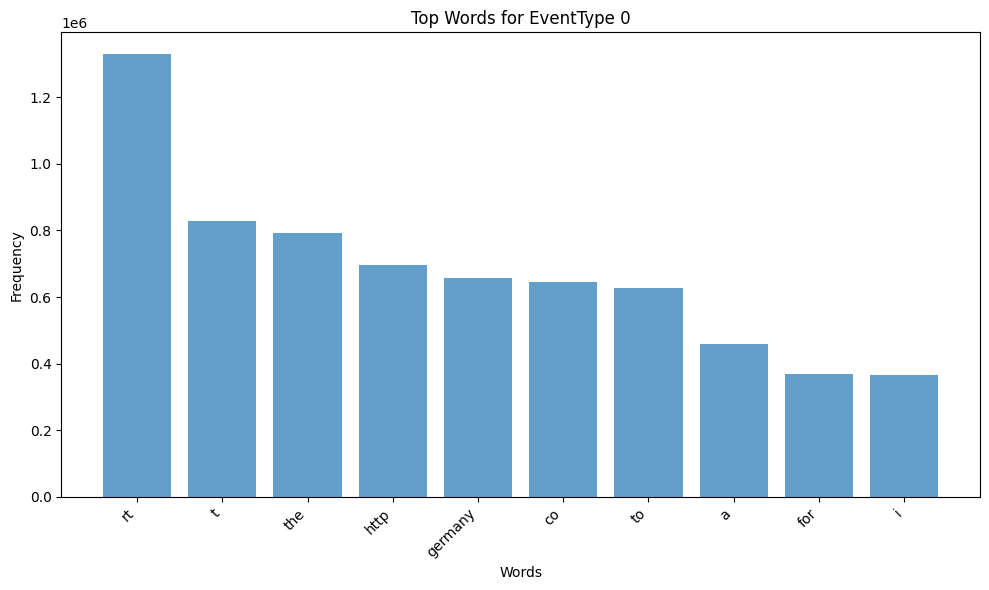

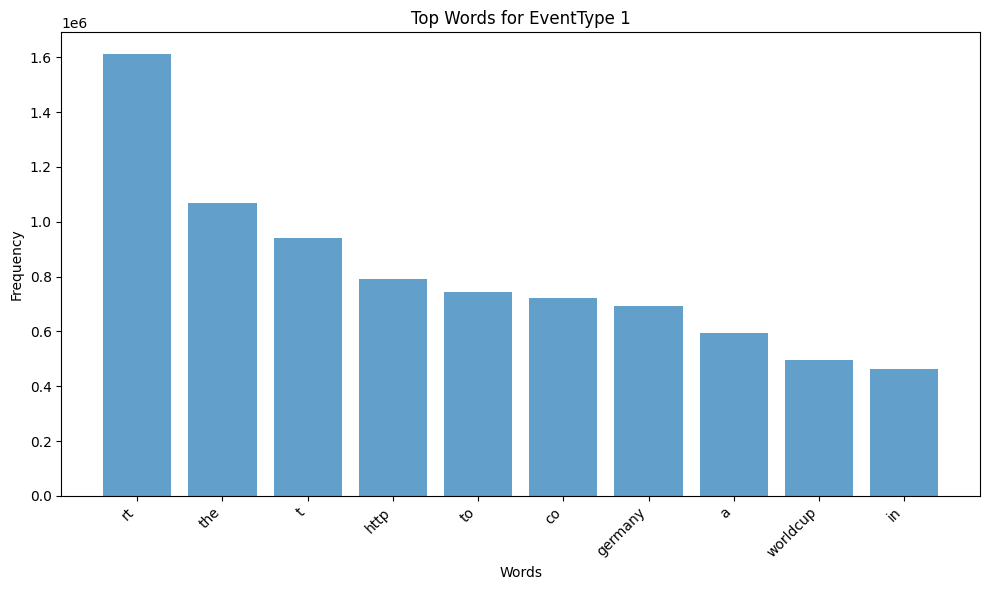

In [50]:
from collections import Counter
import re

# Function to extract words from tweets
def extract_words(text):
    # Remove hashtags, mentions, and non-alphanumeric characters, and split into words
    return re.findall(r'\b\w+\b', text.lower())

# Filter tweets by EventType
print('begin of select')
event_type_0 = df[df['EventType'] == 0]['Tweet']
event_type_1 = df[df['EventType'] == 1]['Tweet']
print('end of select')

# Count word frequencies for each EventType
print('begin of count words 0')
words_0 = Counter(word for tweet in event_type_0 for word in extract_words(tweet))
print('end of count words 0')
print('begin of count words 1')
words_1 = Counter(word for tweet in event_type_1 for word in extract_words(tweet))
print('end of count words 1')

# Convert to DataFrames for easier analysis
words_0_df = pd.DataFrame(words_0.most_common(10), columns=['Word', 'Count'])
words_1_df = pd.DataFrame(words_1.most_common(10), columns=['Word', 'Count'])

# Plot top words for EventType 0
plt.figure(figsize=(10, 6))
plt.bar(words_0_df['Word'], words_0_df['Count'], alpha=0.7)
plt.title("Top Words for EventType 0")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot top words for EventType 1
plt.figure(figsize=(10, 6))
plt.bar(words_1_df['Word'], words_1_df['Count'], alpha=0.7)
plt.title("Top Words for EventType 1")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Top Words Favoring EventType 1 to 0:
                Word  Count_0  Count_1  Ratio_1_to_0  Ratio_0_to_1
502           cmrbra      763    13289     17.416776      0.057416
630        qualified     2405    18926      7.869439      0.127074
597           cromex     1356    10330      7.617994      0.131268
130              cmr    14595    83890      5.747859      0.173978
655               ft     4554    26156      5.743522      0.174109
159            villa     4135    23212      5.613543      0.178141
258  congratulations     3278    17036      5.197071      0.192416
594         deserved     1700     8634      5.078824      0.196896
9             torres     1716     8702      5.071096      0.197196
324       eliminated     4639    23181      4.996982      0.200121
323            tears     2544    12280      4.827044      0.207166
712         congrats     2519    11953      4.745137      0.210742
634     easportsfifa     2345    10888      4.643070      0.215375
164           cahill     

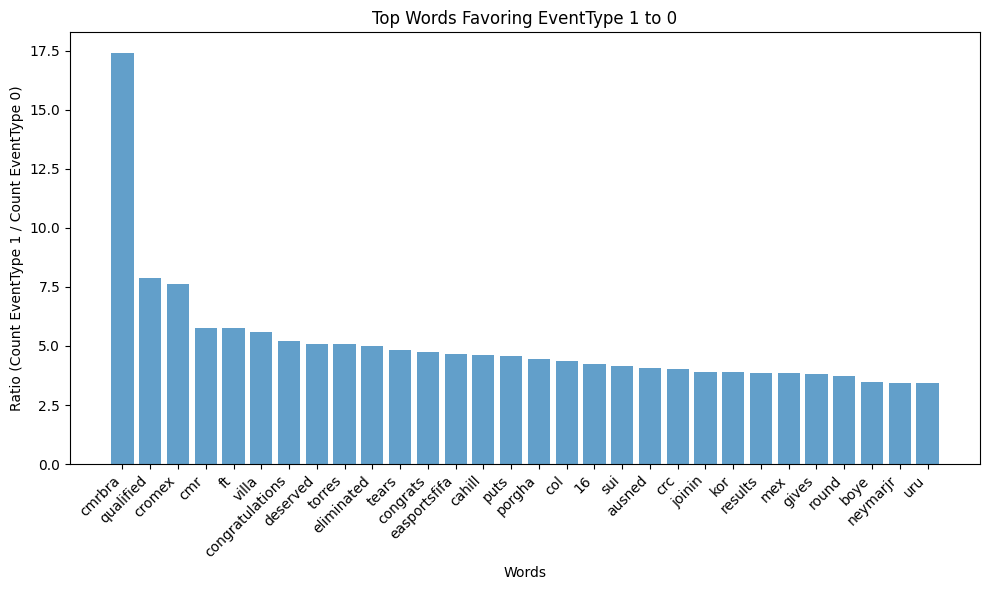

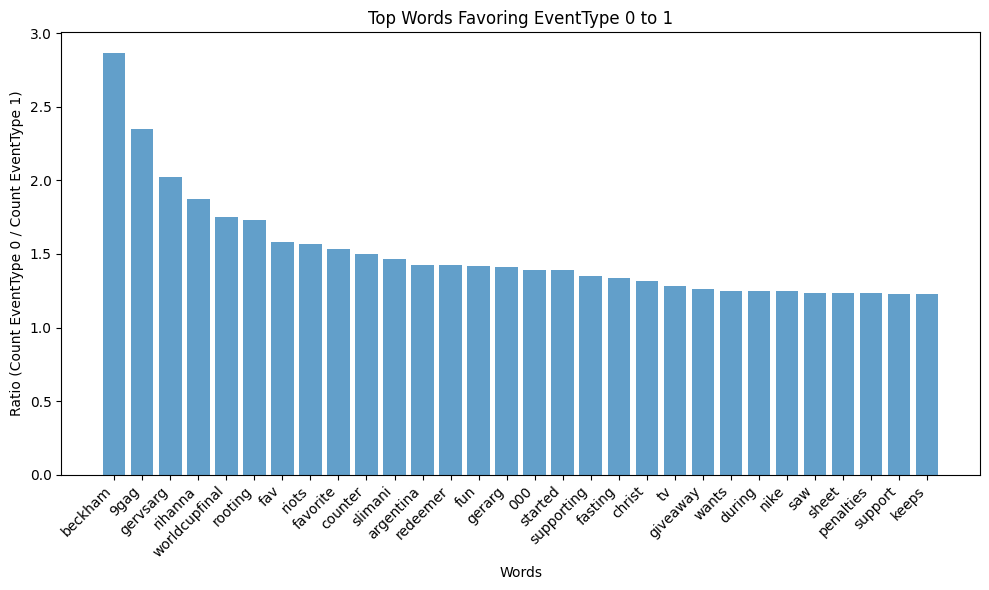

In [53]:
# Set a minimum threshold for word appearances
min_appearance = 1e4
# Combine the counts into a DataFrame for analysis
all_words = set(words_0.keys()).union(set(words_1.keys()))
word_ratios = []

for word in all_words:
    count_0 = words_0.get(word, 0)
    count_1 = words_1.get(word, 0)
    if count_0 + count_1 >= min_appearance:  # Ensure minimum appearances
        ratio_1_to_0 = count_1 / count_0 if count_0 > 0 else float('inf')
        ratio_0_to_1 = count_0 / count_1 if count_1 > 0 else float('inf')
        word_ratios.append({'Word': word, 'Count_0': count_0, 'Count_1': count_1, 
                            'Ratio_1_to_0': ratio_1_to_0, 'Ratio_0_to_1': ratio_0_to_1})

# Convert to a DataFrame for easier analysis
word_ratios_df = pd.DataFrame(word_ratios)

# Find top 10 words with highest EventType 1 to 0 ratios
top_words_1_to_0 = word_ratios_df.sort_values(by='Ratio_1_to_0', ascending=False).head(30)

# Find top 10 words with highest EventType 0 to 1 ratios
top_words_0_to_1 = word_ratios_df.sort_values(by='Ratio_0_to_1', ascending=False).head(30)

# Display the results
print("Top Words Favoring EventType 1 to 0:")
print(top_words_1_to_0)

print("\nTop Words Favoring EventType 0 to 1:")
print(top_words_0_to_1)

# Plot the results for EventType 1 to 0
plt.figure(figsize=(10, 6))
plt.bar(top_words_1_to_0['Word'], top_words_1_to_0['Ratio_1_to_0'], alpha=0.7)
plt.title("Top Words Favoring EventType 1 to 0")
plt.xlabel("Words")
plt.ylabel("Ratio (Count EventType 1 / Count EventType 0)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot the results for EventType 0 to 1
plt.figure(figsize=(10, 6))
plt.bar(top_words_0_to_1['Word'], top_words_0_to_1['Ratio_0_to_1'], alpha=0.7)
plt.title("Top Words Favoring EventType 0 to 1")
plt.xlabel("Words")
plt.ylabel("Ratio (Count EventType 0 / Count EventType 1)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

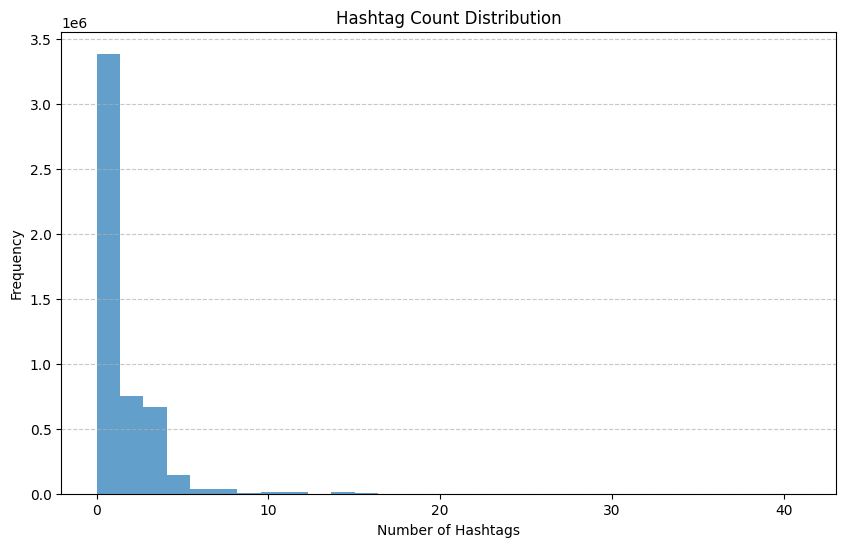

In [29]:
df['Hashtag_Count'] = df['Tweet'].apply(lambda x: x.count('#'))
# Plot histogram of hashtag counts
plt.figure(figsize=(10, 6))
df['Hashtag_Count'].plot(kind='hist', bins=30, alpha=0.7)
plt.title("Hashtag Count Distribution")
plt.xlabel("Number of Hashtags")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

         Hashtag   Count
33           GER  626177
9       WorldCup  566067
21           BRA  279361
75           ARG  265443
5            FRA  216471
25      worldcup  202013
16           MEX  185310
11           NED  174656
17  WorldCup2014  172499
37           POR  150412


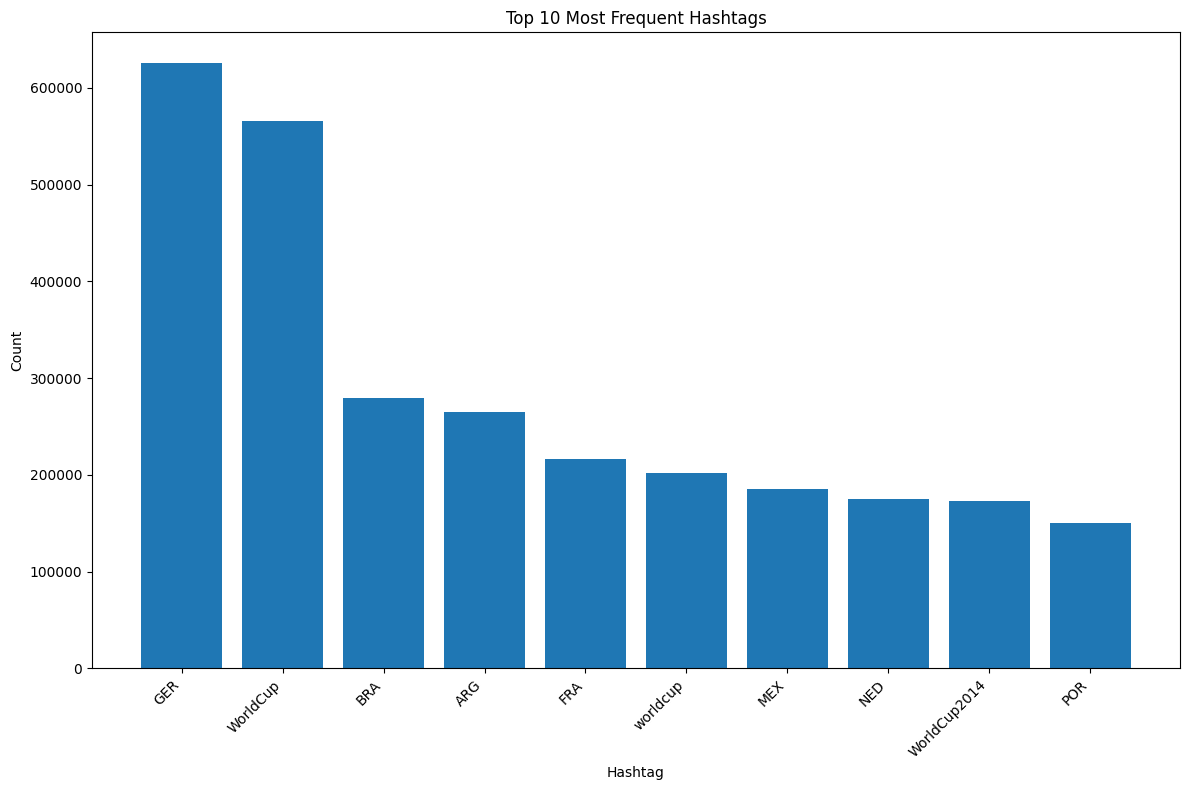

In [46]:

# Function to extract hashtags from a tweet
def extract_hashtags(text):
    return re.findall(r"#(\w+)", text)

# Apply the function to extract hashtags from all tweets
df['Hashtags'] = df['Tweet'].apply(extract_hashtags)

# Flatten the list of lists of hashtags and count occurrences
all_hashtags = [hashtag for hashtags in df['Hashtags'] for hashtag in hashtags]
hashtag_counts = Counter(all_hashtags)

# Convert to a DataFrame for easy analysis
hashtag_df = pd.DataFrame(hashtag_counts.items(), columns=['Hashtag', 'Count']).sort_values(by='Count', ascending=False)

# Display the top 10 most frequent hashtags
top_hashtags = hashtag_df.head(10)
print(top_hashtags)


plt.figure(figsize=(12, 8))
plt.bar(top_hashtags['Hashtag'], top_hashtags['Count'])
plt.title("Top 10 Most Frequent Hashtags")
plt.xlabel("Hashtag")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


(50560, 9)


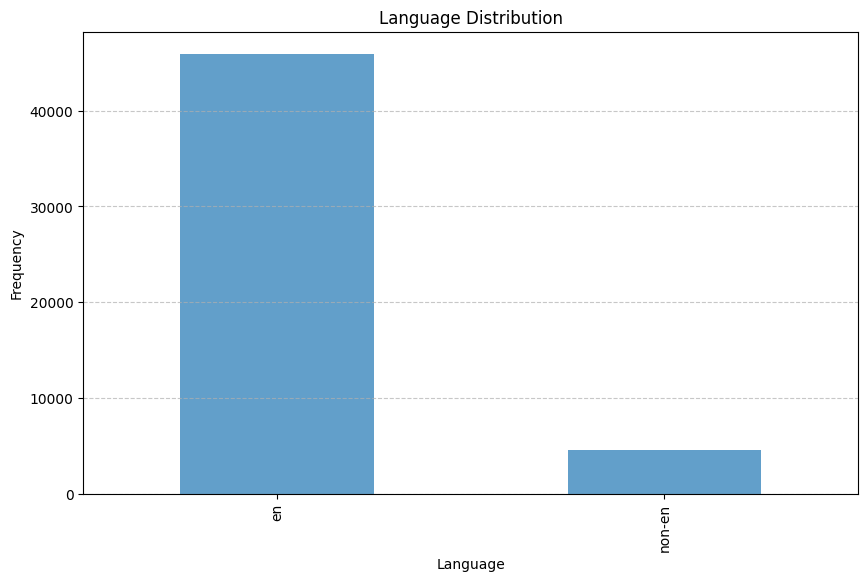

In [34]:
# Sample 10% of the dataset
sampled_df = df.sample(frac=0.01, random_state=42)  # Adjust the random_state for reproducibility
print(sampled_df.shape)

# Function to safely classify a single tweet
def safe_classify(text):
    if text.strip():
        try:
            if classify(text)[0]=='en':
                return 'en'
            else:
                return 'non-en'
        except Exception as e:
            return 'error'  # Return 'error' if classification fails
    else:
        return 'non-en'

# Apply langid to the sampled data
sampled_df['Tweet'] = sampled_df['Tweet'].fillna('').astype(str)
sampled_df['Language'] = sampled_df['Tweet'].apply(safe_classify)

# Plot histogram of language distribution
plt.figure(figsize=(10, 6))
sampled_df['Language'].value_counts().plot(kind='bar', alpha=0.7)
plt.title("Language Distribution")
plt.xlabel("Language")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()